In [6]:
# imports
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

## TODO
- Halving optimization protocol [DONE]
- Adding RF + GP algorithm [DONE]
- Pooling predictions from 10 models
- Visualize output of single model - interpolation schemes
- Generate visualizations for tail behavior
- Experiment with different underlying sample functions

# Data Generation

- As an experiment - if you do evenly spaced points, what happens? (Do over just one model to look at interpolation protocol)
- What about changing underlying distribution

In [7]:
# x between -1 and 1
# y = x^2 + |x| + σ, where σ is N(0, 0.01)
# training data, 20 data points from interval, 400 points as testing data
# rerun algorithms 10 times with different seeds, track mean values and CIs of predicted results

def generate_data(x_lower, x_upper, mean, std, n, seed = 0):
    np.random.seed(seed)
    x_vals = np.random.uniform(x_lower, x_upper, n)
    error_vals = np.random.normal(mean, std, n)
    data =  [(x, (x**2 + abs(x) + n)) for (x, n) in zip(x_vals, error_vals)]
    #return(data)
    x = np.array([d[0] for d in data]).reshape(-1,1)
    y = np.array([d[1] for d in data])
    return x,y

X_train, y_train = generate_data(-1,1,0,0.01,40,0)
X_test, y_test = generate_data(-1,1,0,0.01,400,1)


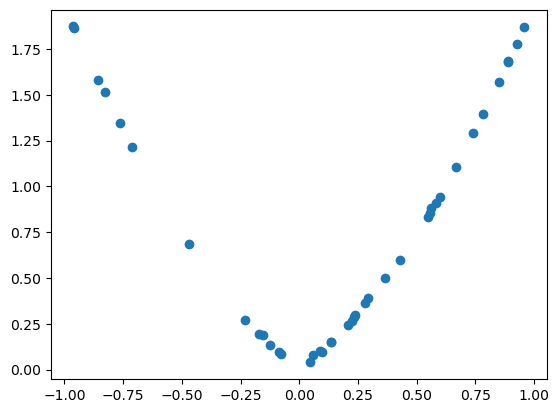

In [8]:
plt.scatter(X_train, y_train)

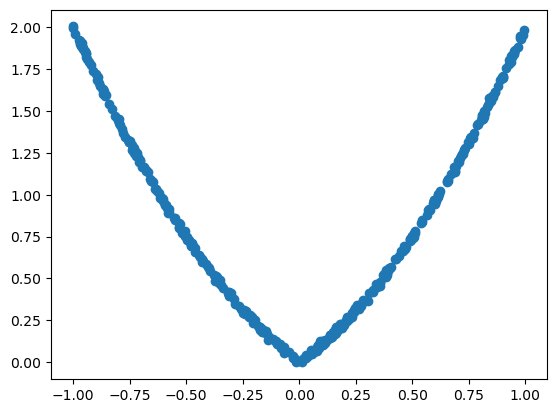

In [9]:
plt.scatter(X_test, y_test)

# Comparing Functions

Default parameters in open-sourse implementations
Fine tune RF, ET, XGBoostm LightGBM, CatBoost using halving-sucecss, provided parameter grid in W. La Cavaet al., “Contemporary symbolic regression methods andtheir relative performance,” 2021,arXiv:2107.14351

Method Hyperparameters

AdaBoost {’learning_rate’: (0.01, 0.1, 1.0, 10.0), ’n_estimators’: (10, 100, 1000)}

KernelRidge {’kernel’: (’linear’, ’poly’, ’rbf’, ’sigmoid’), ’alpha’: (0.0001, 0.01, 0.1, 1), ’gamma’: (0.01,
0.1, 1, 10)}

LassoLars {’alpha’: (0.0001, 0.001, 0.01, 0.1, 1)}

LGBM {’n_estimators’: (10, 50, 100, 250, 500, 1000), ’learning_rate’: (0.0001, 0.01, 0.05, 0.1, 0.2),
’subsample’: (0.5, 0.75, 1), ’boosting_type’: (’gbdt’, ’dart’, ’goss’)}

LinearRegression {’fit_intercept’: (True,)}

MLP {’activation’: (’logistic’, ’tanh’, ’relu’), ’solver’: (’lbfgs’, ’adam’, ’sgd’), ’learning_rate’:
(’constant’, ’invscaling’, ’adaptive’)}

RandomForest {’n_estimators’: (10, 100, 1000), ’min_weight_fraction_leaf’: (0.0, 0.25, 0.5), ’max_features’:
(’sqrt’, ’log2’, None)}

SGD {’alpha’: (1e-06, 0.0001, 0.01, 1), ’penalty’: (’l2’, ’l1’, ’elasticnet’)}

XGB {’n_estimators’: (10, 50, 100, 250, 500, 1000), ’learning_rate’: (0.0001, 0.01, 0.05, 0.1, 0.2),
’gamma’: (0, 0.1, 0.2, 0.3, 0.4), ’subsample’: (0.5, 0.75, 1)}



Metric is MSE


In [10]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor

params = {'n_estimators': (10, 100, 1000), 'min_weight_fraction_leaf': (0.0, 0.25, 0.5), 'max_features': ('sqrt', 'log2', None)}

rfr = RandomForestRegressor(n_estimators = 10, random_state = 0)
#n_estimators was 10 when paper was written

rfr_search = HalvingGridSearchCV(rfr, params, resource = 'n_samples', random_state = 0, n_jobs = -1).fit(X_train, y_train)

rfr.fit(X_train, y_train)

y_pred = rfr_search.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.003988877801100611


In [6]:
# Rotation Forest
# No Implementation?

In [17]:
# Extremely Randomized Trees
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators = 10, random_state = 0)

etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.001209296129602523


In [12]:
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor

params =  {'learning_rate': (0.01, 0.1, 1.0, 10.0), 'n_estimators': (10, 100, 1000)}

abc = AdaBoostRegressor(random_state = 0)

abc_search = HalvingGridSearchCV(abc, params, resource = 'n_samples', random_state = 0, n_jobs = -1).fit(X_train, y_train)


y_pred = abc_search.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.03387282965628614


In [19]:
# Gradient Boosted DT

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state = 0)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.006024847826328323


In [17]:
%%time
# DART
import xgboost as xgb

params = {'n_estimators': (10, 50, 100, 250, 500, 1000), 'learning_rate': (0.0001, 0.01, 0.05, 0.1, 0.2), 'gamma': (0, 0.1, 0.2, 0.3, 0.4), 'subsample': (0.5, 0.75, 1)}

dart_xgb = xgb.XGBRegressor(eval_metric = mean_squared_error, booster = "dart", random_state = 0)

dart_xgb_search = HalvingGridSearchCV(dart_xgb, params, resource = 'n_samples', random_state = 0, n_jobs = -1).fit(X_train, y_train)


y_pred = dart_xgb_search.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.01997938281327365
CPU times: user 1.95 s, sys: 313 ms, total: 2.26 s
Wall time: 58.8 s


In [21]:
# XGBOOST

import xgboost as xgb

tree_xgb = xgb.XGBRegressor(eval_metric = mean_squared_error, random_state = 0)

tree_xgb.fit(X_train, y_train)

y_pred = tree_xgb.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.0238526001285708


In [22]:
# CatBoost

from catboost import CatBoostRegressor

cbm = CatBoostRegressor(random_state = 0, silent = True)
cbm.fit(X_train, y_train)

y_pred = cbm.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.005381760490981801


In [30]:
# Evolutionary Forest (From Paper)
from evolutionary_forest.forest import EvolutionaryForestRegressor
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append

# params from page 742 of original paper
efr = EvolutionaryForestRegressor(random_seed = 0, max_height = 8, n_pop = 60, n_gen = 100, cross_pb = 0.5, gene_num = 5)
#efr = EvolutionaryForestRegressor(random_seed = 0)
efr.fit(X_train, y_train)
y_pred = efr.predict(X_test)
print(mean_squared_error(y_test, y_pred))


Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.


0.0005957727080046963
